In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [4]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import requests 
import json
from dateutil.relativedelta import relativedelta
from datetime import date

In [5]:
## Functions 

def FRSI(series, period=14):
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    return 100 - (100 / (1 + rs))


# calculating Stoch RSI (gives the same values as TradingView)
# https://www.tradingview.com/wiki/Stochastic_RSI_(STOCH_RSI) 
def STRSIA(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.rolling(smoothK).mean()
    stochrsi_D = stochrsi_K.rolling(smoothD).mean()
    return stochrsi, stochrsi_K, stochrsi_D

#Calulate SMA 
def SMA(series,size):
    sma = series.rolling(size).mean()
    return sma
#Calculate SMA55

In [6]:
#whitelist = 'VIDT/USDT, IRIS/USDT, SHIB/USDT,  LINK/USDT, MATIC/USDT, ZRX/USDT,  ALGO/USDT, BTC/USDT, ETH/USDT, AXS/USDT, SOL/USDT, MATIC/USDT, ADA/USDT, BNB/USDT, FIL/USDT, XRP/USDT, CVC/USDT, FTM/USDT, ICP/USDT, DOGE/USDT, XEC/USDT, IOTA/USDT, AVAX/USDT, DOT/USDT, LTC/USDT, EOS/USDT, IOST/USDT, STMX/USDT, FTT/USDT, TWT/USDT, ALICE/USDT, ATA/USDT, ETC/USDT, VET/USDT, SAND/USDT, LINK/USDT, THETA/USDT, SHIB/USDT, CHZ/USDT, LUNA/USDT, IOTX/USDT, TRX/USDT, TLM/USDT, BCH/USDT, REEF/USDT, CAKE/USDT, NEO/USDT, SLP/USDT, RVN/USDT, ATOM/USDT, SUSHI/USDT, ARDR/USDT, OMG/USDT, GRT/USDT, 1INCH/USDT, AAVE/USDT, C98/USDT, UNI/USDT, HBAR/USDT, CRV/USDT, DENT/USDT, MBOX/USDT, BTT/USDT, SRM/USDT, YFI/USDT, HOT/USDT, XLM/USDT, FIS/USDT, REQ/USDT, SXP/USDT, KSM/USDT, QNT/USDT, NEAR/USDT, COMP/USDT, QTUM/USDT, CHR/USDT, SC/USDT, XVS/USDT, ONT/USDT, COTI/USDT, NKN/USDT, RUNE/USDT, ANKR/USDT, MANA/USDT, CTXC/USDT, AR/USDT, RAY/USDT, BAKE/USDT, ARPA/USDT, XTZ/USDT, ZIL/USDT, ONG/USDT, ROSE/USDT, PNT/USDT, ALGO/USDT, MINA/USDT, WIN/USDT, AUDIO/USDT, STORJ/USDT, EPS/USDT, MDX/USDT, ZEC/USDT, ENJ/USDT, HIVE/USDT, TFUEL/USDT, WRX/USDT, SNX/USDT, SKL/USDT, LINA/USDT, DODO/USDT, UNFI/USDT, XEM/USDT, EGLD/USDT, ICX/USDT, WAVES/USDT, ONE/USDT, DASH/USDT, KAVA/USDT, SUPER/USDT, TKO/USDT, OGN/USDT, XMR/USDT, OCEAN/USDT, CELO/USDT, BAT/USDT, FUN/USDT, LRC/USDT, ALPHA/USDT, MASK/USDT, TRU/USDT, DNT/USDT, LIT/USDT, FET/USDT, GTC/USDT, CELR/USDT, DEXE/USDT, ZEN/USDT, WAXP/USDT, CTSI/USDT, HNT/USDT, YFII/USDT, BEL/USDT, ZRX/USDT, DEGO/USDT, RSR/USDT, COS/USDT, FLM/USDT, BAL/USDT, MFT/USDT, RLC/USDT, KNC/USDT, REN/USDT, INJ/USDT, FLOW/USDT, SFP/USDT, BAND/USDT, CTK/USDT, SUN/USDT, AKRO/USDT, XVG/USDT, NANO/USDT, STRAX/USDT, PUNDIX/USDT, TVK/USDT, MKR/USDT, CLV/USDT, TRB/USDT, ETHUP/USDT, KEEP/USDT, TCT/USDT, POND/USDT, LTO/USDT, ANT/USDT, TOMO/USDT, ACM/USDT, FIO/USDT, VITE/USDT, MBL/USDT, JST/USDT, MTL/USDT, UTK/USDT, BLZ/USDT, ORN/USDT, STPT/USDT, CFX/USDT, OM/USDT, PERP/USDT, MIR/USDT, STX/USDT, ERN/USDT, TUSD/USDT, PSG/USDT, NULS/USDT, OXT/USDT, REP/USDT, BNBUP/USDT, DATA/USDT, WAN/USDT, BURGER/USDT, RAMP/USDT, ATM/USDT, DGB/USDT, DIA/USDT, BEAM/USDT, UMA/USDT, ETHDOWN/USDT, CKB/USDT, TRIBE/USDT, FARM/USDT, BTCUP/USDT, BZRX/USDT, ALPACA/USDT, DOTUP/USDT, BTS/USDT, FOR/USDT, ADAUP/USDT, HARD/USDT, LSK/USDT, POLS/USDT, FORTH/USDT, TORN/USDT, VTHO/USDT, BTG/USDT, QUICK/USDT, FILUP/USDT, PAX/USDT, MITH/USDT, SUSHIUP/USDT, BTCDOWN/USDT, XRPDOWN/USDT, BNBDOWN/USDT, DUSK/USDT, XRPUP/USDT, WTC/USDT, DOCK/USDT, AUTO/USDT, BTCST/USDT, KLAY/USDT, WNXM/USDT, KEY/USDT, FILDOWN/USDT, NU/USDT, IRIS/USDT, KMD/USDT, TROY/USDT, WING/USDT, AION/USDT, PHA/USDT, SUSHIDOWN/USDT, EOSUP/USDT, LTCUP/USDT, GHST/USDT, PAXG/USDT, BNT/USDT, AVA/USDT, BADGER/USDT, PERL/USDT, COCOS/USDT, GXS/USDT, MDT/USDT, 1INCHUP/USDT, GTO/USDT, LINKUP/USDT, AAVEUP/USDT, FIRO/USDT, JUV/USDT, MLN/USDT, UNIUP/USDT, LPT/USDT, NMR/USDT, AAVEDOWN/USDT, 1INCHDOWN/USDT, ASR/USDT, OG/USDT, BAR/USDT, DREP/USDT, ADADOWN/USDT, BOND/USDT, DCR/USDT, DOTDOWN/USDT, GNO/USDT, NBS/USDT, SXPUP/USDT, EOSDOWN/USDT, YFIUP/USDT, RIF/USDT, LTCDOWN/USDT, XLMUP/USDT, YFIDOWN/USDT, LINKDOWN/USDT, TRXUP/USDT, BCHUP/USDT, XTZUP/USDT, SXPDOWN/USDT, UNIDOWN/USDT, XTZDOWN/USDT, BCHDOWN/USDT, TRXDOWN/USDT, XLMDOWN/USDT, SUSD/USDT'
whitelist = 'LINK/USDT'
startdate = '2020-01-01'
enddate = '2021-11-09'
interval = '1h'

In [7]:

## get the data 
import os




directory = 'BN-main'
table = []
   
      
dflive = pd.read_json('BN-main/ALGO_USDT-1h.json')
dflive.columns=['open_time','o','h','l','c','v']


dflive.open_time = pd.to_datetime(dflive['open_time'],unit='ms')
#dflive=dflive.loc[(dflive.open_time>start)]
        
dflive = dflive.astype ({'o': float ,'h':float,'l':float ,'c':float ,'v':float})
dflive['RSI'] = FRSI(dflive['c'])
dflive['RSI4']= FRSI(dflive['c'],56)
dflive['RSI8']= FRSI(dflive['c'],112)
dflive['STRSI'] = STRSIA(dflive['c'])[0]
dflive['STRSIK'] = STRSIA(dflive['c'])[1]
dflive['STRSID'] = STRSIA(dflive['c'])[2]

dflive['STRSI4'] = STRSIA(dflive['c'],56,12,12)[0]
dflive['STRSIK4'] = STRSIA(dflive['c'],56,12,12)[1]
dflive['STRSID4'] = STRSIA(dflive['c'],56,12,12)[2]

dflive['STRSI8'] = STRSIA(dflive['c'],112,24,24)[0]
dflive['STRSIK8'] = STRSIA(dflive['c'],112,24,24)[1]
dflive['STRSID8'] = STRSIA(dflive['c'],112,24,24)[2]
dflive['SMA21'] = SMA(dflive['c'],21)
dflive['SMA55'] = SMA(dflive['c'],55)

dflive.tail()

,open_time,o,h,l,c,v,RSI,RSI4,RSI8,STRSI,STRSIK,STRSID,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55
18040,2021-07-14 04:00:00,0.8302,0.8421,0.8280,0.8412,281296.12,39.299892,44.744268,47.346080,0.193580,0.108586,0.075077,0.181689,0.451919,0.451213,0.125329,0.253386,0.249572,0.866586,0.873207
18041,2021-07-14 05:00:00,0.8406,0.8444,0.8296,0.8306,349385.23,35.947606,43.464903,46.678879,0.083097,0.092226,0.081974,0.043073,0.399795,0.457546,0.017244,0.253982,0.248837,0.864776,0.872035
18042,2021-07-14 06:00:00,0.8309,0.8389,0.8242,0.8279,807401.29,35.125709,43.144961,46.510427,0.056010,0.110896,0.103902,0.008408,0.356575,0.457781,0.000000,0.248560,0.248510,0.862790,0.870811
18043,2021-07-14 07:00:00,0.8275,0.8398,0.8266,0.8364,318106.26,39.792694,44.455510,47.116639,0.209821,0.116309,0.106477,0.150403,0.316564,0.452384,0.104201,0.243205,0.248300,0.861352,0.869833
18044,2021-07-14 08:00:00,0.8370,0.8409,0.8242,0.8258,554169.09,36.286908,43.191375,46.454175,0.094280,0.120037,0.115747,0.013437,0.245705,0.437432,0.000000,0.232266,0.247862,0.859733,0.868527


In [8]:
# yes, you can read dataframes from URLs!
#df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df = dflive

In [9]:
df.head()

,open_time,o,h,l,c,v,RSI,RSI4,RSI8,STRSI,STRSIK,STRSID,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55
0,2019-06-22 00:00:00,3.400,3.440,2.621,2.709,2138741.658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-22 01:00:00,2.701,2.796,2.530,2.715,902015.539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-22 02:00:00,2.715,2.749,2.601,2.672,512599.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-06-22 03:00:00,2.675,2.714,2.540,2.554,994259.176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-06-22 04:00:00,2.543,2.562,2.476,2.503,969104.836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.tail()

,open_time,o,h,l,c,v,RSI,RSI4,RSI8,STRSI,STRSIK,STRSID,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55
18040,2021-07-14 04:00:00,0.8302,0.8421,0.8280,0.8412,281296.12,39.299892,44.744268,47.346080,0.193580,0.108586,0.075077,0.181689,0.451919,0.451213,0.125329,0.253386,0.249572,0.866586,0.873207
18041,2021-07-14 05:00:00,0.8406,0.8444,0.8296,0.8306,349385.23,35.947606,43.464903,46.678879,0.083097,0.092226,0.081974,0.043073,0.399795,0.457546,0.017244,0.253982,0.248837,0.864776,0.872035
18042,2021-07-14 06:00:00,0.8309,0.8389,0.8242,0.8279,807401.29,35.125709,43.144961,46.510427,0.056010,0.110896,0.103902,0.008408,0.356575,0.457781,0.000000,0.248560,0.248510,0.862790,0.870811
18043,2021-07-14 07:00:00,0.8275,0.8398,0.8266,0.8364,318106.26,39.792694,44.455510,47.116639,0.209821,0.116309,0.106477,0.150403,0.316564,0.452384,0.104201,0.243205,0.248300,0.861352,0.869833
18044,2021-07-14 08:00:00,0.8370,0.8409,0.8242,0.8258,554169.09,36.286908,43.191375,46.454175,0.094280,0.120037,0.115747,0.013437,0.245705,0.437432,0.000000,0.232266,0.247862,0.859733,0.868527


In [11]:
# Start by doing the WRONG thing - trying to predict the price itself
#series = df['c'].values.reshape(-1, 1)

In [12]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

In [13]:
# calculate returns by first shifting the data
df['PrevClose'] = df['c'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [14]:
df.head()

,open_time,o,h,l,c,v,RSI,RSI4,RSI8,STRSI,...,STRSID,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55,PrevClose
0,2019-06-22 00:00:00,3.400,3.440,2.621,2.709,2138741.658,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-22 01:00:00,2.701,2.796,2.530,2.715,902015.539,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.709
2,2019-06-22 02:00:00,2.715,2.749,2.601,2.672,512599.433,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.715
3,2019-06-22 03:00:00,2.675,2.714,2.540,2.554,994259.176,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.672
4,2019-06-22 04:00:00,2.543,2.562,2.476,2.503,969104.836,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.554


In [15]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['c'] - df['PrevClose']) / df['PrevClose']

In [16]:
df.tail()

,open_time,o,h,l,c,v,RSI,RSI4,RSI8,STRSI,...,STRSI4,STRSIK4,STRSID4,STRSI8,STRSIK8,STRSID8,SMA21,SMA55,PrevClose,Return
18040,2021-07-14 04:00:00,0.8302,0.8421,0.8280,0.8412,281296.12,39.299892,44.744268,47.346080,0.193580,...,0.181689,0.451919,0.451213,0.125329,0.253386,0.249572,0.866586,0.873207,0.8304,0.013006
18041,2021-07-14 05:00:00,0.8406,0.8444,0.8296,0.8306,349385.23,35.947606,43.464903,46.678879,0.083097,...,0.043073,0.399795,0.457546,0.017244,0.253982,0.248837,0.864776,0.872035,0.8412,-0.012601
18042,2021-07-14 06:00:00,0.8309,0.8389,0.8242,0.8279,807401.29,35.125709,43.144961,46.510427,0.056010,...,0.008408,0.356575,0.457781,0.000000,0.248560,0.248510,0.862790,0.870811,0.8306,-0.003251
18043,2021-07-14 07:00:00,0.8275,0.8398,0.8266,0.8364,318106.26,39.792694,44.455510,47.116639,0.209821,...,0.150403,0.316564,0.452384,0.104201,0.243205,0.248300,0.861352,0.869833,0.8279,0.010267
18044,2021-07-14 08:00:00,0.8370,0.8409,0.8242,0.8258,554169.09,36.286908,43.191375,46.454175,0.094280,...,0.013437,0.245705,0.437432,0.000000,0.232266,0.247862,0.859733,0.868527,0.8364,-0.012673


In [17]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()
print (series)

[ 0.14674588 -0.97083335 -2.72424907 ... -0.19160268  0.64522104
 -0.77492644]


In [18]:
## scale all data


In [19]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
#input_data = df[['o', 'h', 'l', 'c', 'v','RSI','RSI4','RSI8','STRSI','STRSI4','STRSI8','STRSIK4','STRSID4']].values
input_data = df[['v','RSI','RSI4','RSI8','STRSI','STRSI4','STRSI8','STRSIK4','STRSID4']].values
targets = df['Return'].values
print(targets)

[        nan  0.00221484 -0.01583794 ... -0.00325066  0.01026694
 -0.01267336]


In [20]:
# Now make the actual data which will go into the neural network
T = 8 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)
print(N)

18037


In [21]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)
print(input_data)


[[ 1.8807307          nan         nan ...         nan         nan
          nan]
 [ 0.38859132         nan         nan ...         nan         nan
          nan]
 [-0.08124845         nan         nan ...         nan         nan
          nan]
 ...
 [ 0.27443698 -1.29537303 -1.04738809 ... -1.61226242 -0.44965884
  -0.0861046 ]
 [-0.31590907 -0.86159164 -0.81690721 ... -1.25908032 -0.59422988
  -0.10638809]
 [-0.03109367 -1.18744326 -1.03922553 ... -1.61226242 -0.85026276
  -0.16259047]]


In [22]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0.01)

print(X_train)

[[[ 1.8807307          nan         nan ...         nan         nan
           nan]
  [ 0.38859132         nan         nan ...         nan         nan
           nan]
  [-0.08124845         nan         nan ...         nan         nan
           nan]
  ...
  [-0.10716932         nan         nan ...         nan         nan
           nan]
  [-0.05534621         nan         nan ...         nan         nan
           nan]
  [-0.33848963         nan         nan ...         nan         nan
           nan]]

 [[ 0.38859132         nan         nan ...         nan         nan
           nan]
  [-0.08124845         nan         nan ...         nan         nan
           nan]
  [ 0.49988545         nan         nan ...         nan         nan
           nan]
  ...
  [-0.05534621         nan         nan ...         nan         nan
           nan]
  [-0.33848963         nan         nan ...         nan         nan
           nan]
  [-0.21353771         nan         nan ...         nan         nan
      

In [23]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0.01)
print(Y_test)

[1. 0. 0. ... 0. 1. 0.]


In [24]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

In [23]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=24,
  epochs=10,
  validation_data=(X_test, Y_test),
)

Train on 12030 samples, validate on 6007 samples
Epoch 1/10
12030/12030 [==============================] - 12s 1ms/sample - loss: nan - accuracy: 0.8183 - val_loss: nan - val_accuracy: 0.7471
Epoch 2/10
12030/12030 [==============================] - 8s 644us/sample - loss: nan - accuracy: 0.8205 - val_loss: nan - val_accuracy: 0.7471
Epoch 3/10
12030/12030 [==============================] - 8s 647us/sample - loss: nan - accuracy: 0.8205 - val_loss: nan - val_accuracy: 0.7471
Epoch 4/10
12030/12030 [==============================] - 7s 583us/sample - loss: nan - accuracy: 0.8205 - val_loss: nan - val_accuracy: 0.7471
Epoch 5/10
12030/12030 [==============================] - 7s 564us/sample - loss: nan - accuracy: 0.8205 - val_loss: nan - val_accuracy: 0.7471
Epoch 6/10
12030/12030 [==============================] - 7s 608us/sample - loss: nan - accuracy: 0.8205 - val_loss: nan - val_accuracy: 0.7471
Epoch 7/10
12030/12030 [==============================] - 7s 616us/sample - loss: nan - 

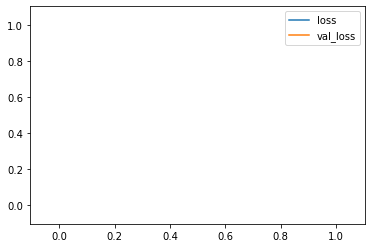

In [24]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

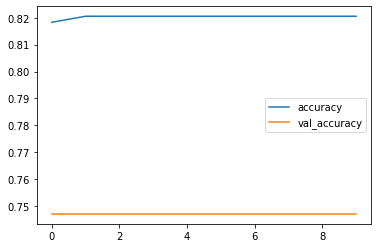

In [25]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

(6007, 1)


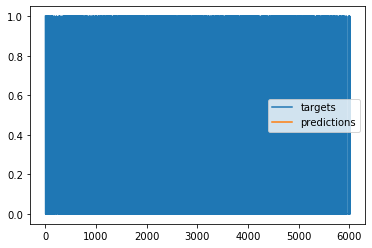

In [26]:
# One-step forecast using true targets
outputs = model.predict(X_test)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y_test, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()